> Module link: https://dev.mrdbourke.com/tensorflow-deep-learning/09_SkimLit_nlp_milestone_project_2/#exercises

## 1. Train model_5 on all of the data in the training dataset for as many epochs until it stops improving. Since this might take a while, you might want to use:
* tf.keras.callbacks.ModelCheckpoint to save the model's best weights only.
* tf.keras.callbacks.EarlyStopping to stop the model from training once the validation loss has stopped improving for ~3 epochs.

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 0), reused 0 (delta 0), pack-reused 30
Unpacking objects: 100% (33/33), done.


In [ ]:
!ls pubmed-rct

PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [ ]:
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [ ]:
import os

filenames = [data_dir+ filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

In [ ]:
def get_lines(filename):
  with open(filename, "r") as f:
    return f.readlines()

In [ ]:
train_lines = get_lines("pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt")

train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
def preprocess_text_with_line_numbers(filename):
  """
  output: 
  [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  all_lines = get_lines(filename)
  processed_lines = []
  current_abstract = []

  for line in all_lines:
    if line.startswith("###"):
      current_abstract = []
    elif line.startswith("\n"):
      for i in range(len(current_abstract)):
        current_abstract[i]["line_number"] = i
        current_abstract[i]["total_lines"] = len(current_abstract)-1
        processed_lines.append(current_abstract[i])
    else:
      key, value = line[:line.find("\t")], line[line.find("\t")+1:]
      line_data = {}
      line_data["target"] = key
      line_data["text"] = value
      current_abstract.append(line_data)

  return processed_lines

In [ ]:
train_data = preprocess_text_with_line_numbers("pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt")
train_data[:10]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'Pain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'Secondary outcome measures

In [ ]:
%%time
train_samples = preprocess_text_with_line_numbers(data_dir+ "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir+ "dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir+ "test.txt")

CPU times: user 407 ms, sys: 112 ms, total: 519 ms
Wall time: 517 ms


In [ ]:
len(train_samples), len(test_samples), len(val_samples)

(180040, 30135, 30212)

In [ ]:
import pandas as pd
train_df = (pd.DataFrame(train_samples))
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

train_df.head(14)

target  ... total_lines
0     OBJECTIVE  ...          11
1       METHODS  ...          11
2       METHODS  ...          11
3       METHODS  ...          11
4       METHODS  ...          11
5       METHODS  ...          11
6       RESULTS  ...          11
7       RESULTS  ...          11
8       RESULTS  ...          11
9       RESULTS  ...          11
10      RESULTS  ...          11
11  CONCLUSIONS  ...          11
12   BACKGROUND  ...          10
13   BACKGROUND  ...          10

[14 rows x 4 columns]

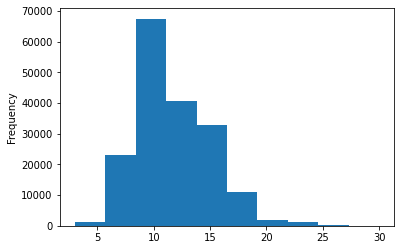

In [ ]:
train_df.total_lines.plot.hist()

In [ ]:
train_sentences = train_df['text']
test_sentences = test_df['text']
val_sentences = val_df['text']
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1, 1)) #.reshape(-1, 1)
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df['target'].to_numpy().reshape(-1, 1))

train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_label_encoded = label_encoder.fit_transform(train_df['target'])
test_label_encoded = label_encoder.transform(test_df["target"])
val_label_encoded = label_encoder.transform(val_df["target"])
train_label_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_

num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-01-09 12:44:03--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-01-09 12:44:03 (84.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, losses, optimizers, Sequential
import numpy as np

sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sentence_len = np.mean(sent_lens)
avg_sentence_len

26.338269273494777

In [ ]:
import matplotlib.pyplot as plt

plt.hist(sent_lens, bins=7)

(array([1.5999e+05, 1.8760e+04, 1.1510e+03, 9.9000e+01, 2.8000e+01,
        1.0000e+01, 2.0000e+00]),
 array([  1.        ,  43.14285714,  85.28571429, 127.42857143,
        169.57142857, 211.71428571, 253.85714286, 296.        ]),
 <a list of 7 Patch objects>)

In [ ]:
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len, max(sent_lens)

(55, 296)

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
max_tokens = 68000

text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    output_sequence_length=output_seq_len)

text_vectorizer.adapt(train_sentences)

In [ ]:
import random
target_sentence = random.choice(train_sentences)
print(f"\nText: \n {target_sentence}")
print(f"\nLength: \n {len(target_sentence)}")
print(f"\nVectorizer: \n {text_vectorizer(target_sentence)}")


Text: 
 Patients were unaware of the episiotomy type performed .


Length: 
 57

Vectorizer: 
 [   12     9  6246     4     2 10369   248   153     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0]


In [ ]:
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"first 6 words in vocab: {rct_20k_text_vocab[:6]}")
print(f"last 6 words in vocab: {rct_20k_text_vocab[-6:]}")
text_vectorizer.get_config()

number of words in vocab: 64841
first 6 words in vocab: ['', '[UNK]', 'the', 'and', 'of', 'in']
last 6 words in vocab: ['aana', 'aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


{'batch_input_shape': (None, None),
 'dtype': 'string',
 'idf_weights': None,
 'max_tokens': 68000,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'ragged': False,
 'sparse': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True,
 'vocabulary': None}

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))

print(train_dataset)

train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<TensorSliceDataset shapes: ((), (5,)), types: (tf.string, tf.float64)>


<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

In [ ]:
#  Embeding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab),
                               output_dim=128,
                               mask_zero=True,
                               name="token_embedding")

target_sentence = random.choice(train_sentences)
print(f"Text: \n", target_sentence)
vectorized_text = text_vectorizer(target_sentence)
print(f"\Vectorized-Text: \n", vectorized_text)
embed_text = token_embed(vectorized_text)
print(f"\nEmbed-Text: \n", embed_text)
embed_text.shape, vectorized_text.shape , len(rct_20k_text_vocab)

Text: 
 Adverse reactions in the ferrous sulfate group were @ % , compared with @ % in the iron amino acid chelate group ; @ children had respiratory tract infection , without statistical differences .

\Vectorized-Text: 
 tf.Tensor(
[  118  1176     5     2  5917  2680    13     9    34     7     5     2
  1021  2729   386 11706    13   109    55   589  1415   360   159   462
   102     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0], shape=(55,), dtype=int64)

Embed-Text: 
 tf.Tensor(
[[ 0.00586503 -0.00317562 -0.04128287 ...  0.01324787 -0.047697
  -0.0091133 ]
 [ 0.04271122  0.00078459  0.01092861 ... -0.02125781  0.00817119
  -0.01944293]
 [-0.0208524   0.04076007 -0.00802533 ...  0.00694237  0.04748936
  -0.04923281]
 ...
 [ 0.04447228 -0.03156354  0.01457715 ...  0.00182638 -0.00135069
  -0.01402582]
 [ 0.04447228 -0.03156354  0.01457715 ...  0.00182

(TensorShape([55, 128]), TensorShape([55]), 64841)

In [ ]:
# Model-1
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = token_embed(x)
x = layers.Conv1D(64, 5, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
output = layers.Dense(num_classes, activation="softmax")(x)

model_1 = tf.keras.Model(inputs, output)

model_1.compile(loss=losses.categorical_crossentropy,
                optimizer=optimizers.Adam(),
                metrics=["accuracy"])

model_1_history = model_1.fit(train_dataset,
                              epochs=5,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              validation_data=val_dataset,
                              validation_steps=int(0.1 * len(val_dataset))
                              )

Epoch 1/5
562/562 [==============================] - 58s 102ms/step - loss: 0.9446 - accuracy: 0.6279 - val_loss: 0.7192 - val_accuracy: 0.7261
Epoch 2/5
562/562 [==============================] - 57s 101ms/step - loss: 0.6832 - accuracy: 0.7464 - val_loss: 0.6591 - val_accuracy: 0.7670
Epoch 3/5
562/562 [==============================] - 57s 101ms/step - loss: 0.6370 - accuracy: 0.7668 - val_loss: 0.6131 - val_accuracy: 0.7793
Epoch 4/5
562/562 [==============================] - 57s 101ms/step - loss: 0.6050 - accuracy: 0.7811 - val_loss: 0.5923 - val_accuracy: 0.7859
Epoch 5/5
562/562 [==============================] - 57s 101ms/step - loss: 0.6011 - accuracy: 0.7877 - val_loss: 0.5696 - val_accuracy: 0.7965


In [ ]:
def split_chars(text):
  return " ".join(list(text))

split_chars("Malik Samad")

'M a l i k   S a m a d'

In [ ]:
train_chars = [split_chars(sentence) for sentence in train_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]

train_chars[1]

'A   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   O A   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   . \n'

In [ ]:
char_lens = [len(sentence) for sentence in train_chars]
mean_char_len = np.mean(char_lens)
mean_char_len, plt.hist(char_lens, bins=7)

(299.7325149966674,
 (array([1.41175e+05, 3.71110e+04, 1.60000e+03, 1.27000e+02, 2.10000e+01,
         5.00000e+00, 1.00000e+00]),
  array([   3.        ,  398.71428571,  794.42857143, 1190.14285714,
         1585.85714286, 1981.57142857, 2377.28571429, 2773.        ]),
  <a list of 7 Patch objects>))

In [ ]:
output_seq_len = int(np.percentile(char_lens, 95))
output_seq_len

581

In [ ]:
import string
alphabets = string.ascii_lowercase + string.digits + string.punctuation
num_char_token = len(alphabets)
char_vectorizer = TextVectorization(max_tokens=num_char_token,
                                    output_sequence_length=output_seq_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

char_vectorizer.adapt(train_chars)

In [ ]:
char_embed = layers.Embedding(input_dim=num_char_token,
                              output_dim=25,
                              mask_zero=True,
                              name="char_embed")

In [ ]:
train_line_number_one_hot = tf.one_hot(train_df["line_number"], depth=15)
test_line_number_one_hot = tf.one_hot(test_df["line_number"], depth=15)
val_line_number_one_hot = tf.one_hot(val_df["line_number"], depth=15)

train_line_number_one_hot.shape, train_line_number_one_hot[:10]

(TensorShape([180040, 15]), <tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>)

In [ ]:
train_total_line_one_hot = tf.one_hot(train_df['total_lines'], depth=20)
test_total_line_one_hot = tf.one_hot(test_df['total_lines'], depth=20)
val_total_line_one_hot = tf.one_hot(val_df['total_lines'], depth=20)

train_total_line_one_hot[:10]

<tf.Tensor: shape=(10, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
     

In [ ]:
import tensorflow_hub as hub

use_embed_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", 
                                 trainable=False,
                                 name="use_embed_layer")

# token model
token_inputs = layers.Input(shape=(), name="token_inputs", dtype="string")
# x = text_vectorizer(token_inputs)
# x = token_embed(x)
# x = layers.GlobalAveragePooling1D(name="avg_pooling_1d")(x)
x = use_embed_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(x)
token_model = tf.keras.Model(token_inputs, token_output)

# chart model
char_inputs = layers.Input(shape=(1,), name="char_inputs", dtype="string")
y = char_vectorizer(char_inputs)
y = char_embed(y)
char_output = layers.Bidirectional(layers.LSTM(32), name="bi_direction_lstm_output")(y)
# char_output = layers.Dense(128, activation="relu", name="chart_output")(y)
char_model = tf.keras.Model(char_inputs, char_output)

# lineNumber model
line_number_inputs = layers.Input(shape=(15,), name="line_number_input")
line_number_output = layers.Dense(32, activation="relu", name="line_number_output")(line_number_inputs)
line_number_model = tf.keras.Model(line_number_inputs,
                                   line_number_output)

# totalLines model
total_lines_inputs = layers.Input(shape=(20,), name="total_line_input")
total_lines_output = layers.Dense(32, activation="relu", name="total_line_output")(total_lines_inputs)
total_lines_model = tf.keras.Model(total_lines_inputs,
                                  total_lines_output)

# combine token and char models
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embed")([token_model.output,
                                                                         char_model.output])
# add extra learning space after character and token embed model
z = layers.Dense(128, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# add in line number and total lines model
z = layers.Concatenate(name="token_char_positional")([line_number_model.output,
                                                      total_lines_model.output,
                                                      z])

output_layer = layers.Dense(num_classes, activation="softmax")(z)

model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_lines_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer)

# compile
model_5.compile(loss=losses.categorical_crossentropy,
                optimizer=optimizers.Adam(),
                metrics=["accuracy"])

# summary
model_5.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 581)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 use_embed_layer (KerasLayer)   (None, 512)          256797824   ['token_inputs[0][0]']     

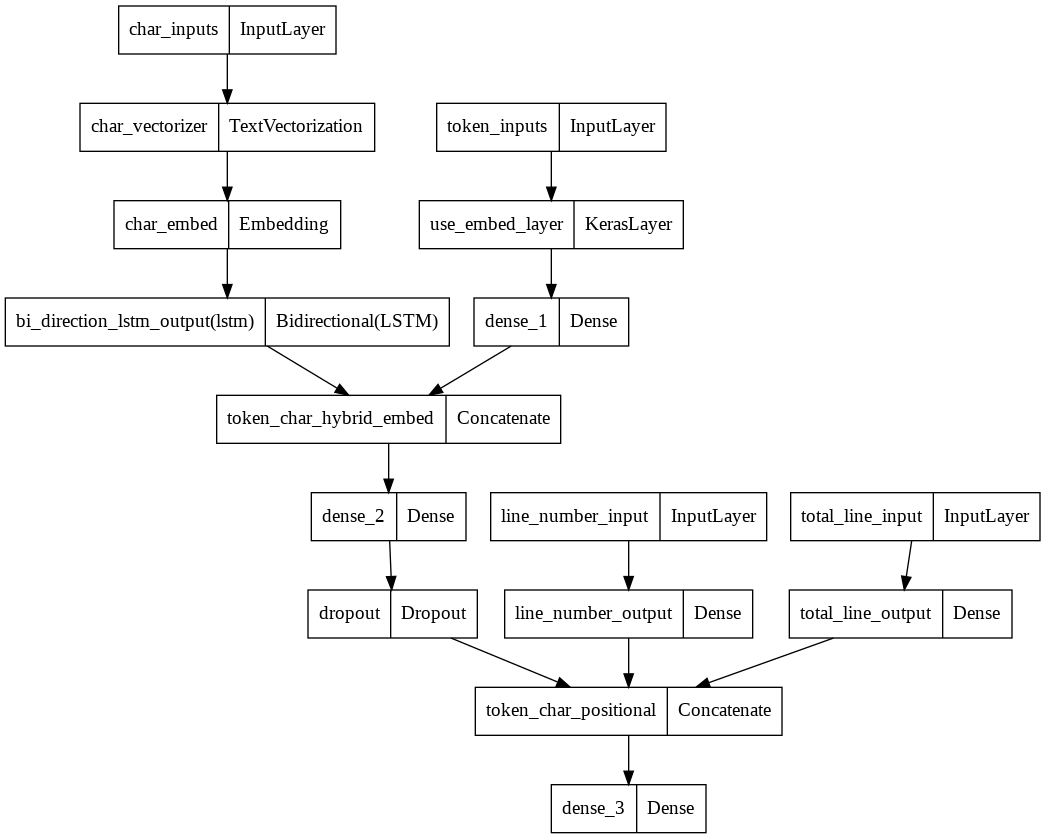

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model_5)

In [ ]:
# train dataset
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_number_one_hot,
                                                                   train_total_line_one_hot,
                                                                   train_sentences,
                                                                   train_chars))
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels))
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# test dataset
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_line_number_one_hot,
                                                               test_total_line_one_hot,
                                                               test_sentences,
                                                               test_chars
                                                               ))
test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data, test_pos_char_token_labels))
test_pos_char_token_dataset = test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# val dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_number_one_hot,
                                                              val_total_line_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
model_5_history = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)),
                              callbacks=[tf.keras.callbacks.ModelCheckpoint("/Model_Checkpoints/model_5", monitor="val_accuracy", save_best_only=True),
                                         tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3 )])

562/562 [==============================] - ETA: 0s - loss: 0.4728 - accuracy: 0.8184

INFO:tensorflow:Assets written to: /Model_Checkpoints/model_5/assets


INFO:tensorflow:Assets written to: /Model_Checkpoints/model_5/assets


562/562 [==============================] - 443s 788ms/step - loss: 0.4728 - accuracy: 0.8184 - val_loss: 0.4465 - val_accuracy: 0.8291


In [ ]:
evaluation_result = model_5.evaluate(val_pos_char_token_dataset)

945/945 [==============================] - 121s 128ms/step - loss: 0.4563 - accuracy: 0.8241


In [ ]:
model_5_preds_probs = model_5.predict(test_pos_char_token_dataset)

In [ ]:
from helper_functions import calculate_results

model_5_preds = np.argmax(model_5_preds_probs, axis=1)
calculate_results(test_label_encoded, model_5_preds)

{'accuracy': 82.05740832918534,
 'f1': 0.8188900117220924,
 'precision': 0.8244186580387598,
 'recall': 0.8205740832918533}

##3. What happens if you were to merge our line_number and total_lines features for each sequence? For example, created a X_of_Y feature instead? Does this effect model performance?
* Another example: line_number=1 and total_lines=11 turns into line_of_X=1_of_11.

In [ ]:
# x_of_y vectorizer
x_of_y_train_data = np.array([f"{line['line_number']}_of_{line['total_lines']}" for line in train_samples])
x_of_y_test_data = np.array([f"{line['line_number']}_of_{line['total_lines']}" for line in test_samples])
x_of_y_val_data = np.array([f"{line['line_number']}_of_{line['total_lines']}" for line in val_samples])

x_of_y_lens = [len(value) for value in x_of_y_train_data]

x_of_y_vectorizer = TextVectorization(max_tokens=len(set(x_of_y_train_data)),
                                      output_sequence_length=int(np.amax(x_of_y_lens)),
                                    standardize="lower_and_strip_punctuation",
                                      name="x_of_y_vectorizer")

x_of_y_vectorizer.adapt(x_of_y_train_data)

In [ ]:
# token model
token_inputs = layers.Input(shape=[], dtype="string", name="token_input")
x = use_embed_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(x)
token_model = tf.keras.Model(token_inputs, token_output)

# char model
char_inputs = layers.Input(shape=(1,), dtype="string", name="chart_input")
x = char_vectorizer(char_inputs)
x = char_embed(x)
x = layers.GlobalAveragePooling1D(name="global_avg_pool-1d")(x)
char_output_layer = layers.Dense(128, activation="relu")(x)
char_model = tf.keras.Model(char_inputs, char_output_layer)

# x_of_y positional model
x_of_y_input = layers.Input(shape=(1,), dtype="string", name="x_of_y_input")
x = x_of_y_vectorizer(x_of_y_input) 
print(x.shape)
x = layers.Embedding(input_dim=len(set(x_of_y_train_data)),
                     output_dim=32,
                     mask_zero=True)(x) 
x = layers.GlobalAveragePooling1D(name="global_avg_pool_1")(x)
print(x.shape)
x_of_y_output = layers.Dense(32, activation="relu", name="x_of_y_output")(x)
x_of_y_model = tf.keras.Model(x_of_y_input, x_of_y_output)

# combine char and token models with some learning space
combined_layer = layers.Concatenate(name="combined_layer_token_char")([token_model.output,
                                                                       char_model.output])
y = layers.Dense(128, activation="relu")(combined_layer)
y = layers.Dropout(0.5)(y)

# combine with x_of_y model
z = layers.Concatenate(name="x_of_y_concat")([x_of_y_model.output,
                                              y])

output_layer = layers.Dense(num_classes, activation="softmax")(z)

model_6 = tf.keras.Model(inputs=[x_of_y_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer)

model_6.compile(loss=losses.categorical_crossentropy,
                optimizer=optimizers.Adam(),
                metrics=["accuracy"])

model_6.summary()

(None, 8)
(None, 32)
Model: "model_25"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 chart_input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 581)         0           ['chart_input[0][0]']            
 tion)                                                                                            
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_embed (Embedding)         (None, 581, 25)      1700        ['cha

In [ ]:
x_of_y_train_data.shape, train_sentences.shape

((180040,), (180040,))

In [ ]:
train_data = tf.data.Dataset.from_tensor_slices((x_of_y_train_data,
                                                    np.array(train_sentences),
                                                    np.array(train_chars)))
train_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_dataset = tf.data.Dataset.zip((train_data, train_labels))
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

test_data = tf.data.Dataset.from_tensor_slices((x_of_y_test_data,
                                                    np.array(test_sentences),
                                                    np.array(test_chars)))
test_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_dataset = tf.data.Dataset.zip((test_data, test_labels))
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset, train_pos_char_token_dataset

(<PrefetchDataset shapes: (((None,), (None,), (None,)), (None, 5)), types: ((tf.string, tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>)

In [ ]:
model_6.fit(train_dataset,
            steps_per_epoch=int(0.1 * len(train_dataset)),
            validation_data=test_dataset,
            validation_steps=int(0.1 * len(test_dataset)),
            # epochs=3,
            callbacks=[tf.keras.callbacks.ModelCheckpoint("checkpoint/model_6", monitor="val_accuracy", save_best_only=True),
                       tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=3)]
            )

562/562 [==============================] - ETA: 0s - loss: nan - accuracy: 0.1189INFO:tensorflow:Assets written to: checkpoint/model_6/assets


INFO:tensorflow:Assets written to: checkpoint/model_6/assets


562/562 [==============================] - 75s 134ms/step - loss: nan - accuracy: 0.1189 - val_loss: nan - val_accuracy: 0.1170


## 4. Write a function (or series of functions) to take a sample abstract string, preprocess it (in the same way our model has been trained), make a prediction on each sequence in the abstract and return the abstract in the format:
* PREDICTED_LABEL: SEQUENCE
* PREDICTED_LABEL: SEQUENCE
* PREDICTED_LABEL: SEQUENCE
* PREDICTED_LABEL: SEQUENCE
* ...
> You can find your own unstrcutured RCT abstract from PubMed or try this one from: Baclofen promotes alcohol abstinence in alcohol dependent cirrhotic patients with hepatitis C virus (HCV) infection.

In [ ]:
abstract = "Hepatitis C virus (HCV) and alcoholic liver disease (ALD), either alone or in combination, count for more than two thirds of all liver diseases in the Western world. There is no safe level of drinking in HCV-infected patients and the most effective goal for these patients is total abstinence. Baclofen, a GABA(B) receptor agonist, represents a promising pharmacotherapy for alcohol dependence (AD). Previously, we performed a randomized clinical trial (RCT), which demonstrated the safety and efficacy of baclofen in patients affected by AD and cirrhosis. The goal of this post-hoc analysis was to explore baclofen's effect in a subgroup of alcohol-dependent HCV-infected cirrhotic patients. Any patient with HCV infection was selected for this analysis. Among the 84 subjects randomized in the main trial, 24 alcohol-dependent cirrhotic patients had a HCV infection; 12 received baclofen 10mg t.i.d. and 12 received placebo for 12-weeks. With respect to the placebo group (3/12, 25.0%), a significantly higher number of patients who achieved and maintained total alcohol abstinence was found in the baclofen group (10/12, 83.3%; p=0.0123). Furthermore, in the baclofen group, compared to placebo, there was a significantly higher increase in albumin values from baseline (p=0.0132) and a trend toward a significant reduction in INR levels from baseline (p=0.0716). In conclusion, baclofen was safe and significantly more effective than placebo in promoting alcohol abstinence, and improving some Liver Function Tests (LFTs) (i.e. albumin, INR) in alcohol-dependent HCV-infected cirrhotic patients. Baclofen may represent a clinically relevant alcohol pharmacotherapy for these patients."

all_lines = abstract.split(". ")
processed_lines = []
for index, line in enumerate(all_lines):
  processed_line = {}
  processed_line["text"] = line
  processed_line["line_number"] = index
  processed_line["total_lines"] = len(all_lines)-1
  processed_line["x_of_y_lines"] = f"{index}_of_{len(all_lines)-1}"
  processed_lines.append(processed_line)

processed_lines

[{'line_number': 0,
  'text': 'Hepatitis C virus (HCV) and alcoholic liver disease (ALD), either alone or in combination, count for more than two thirds of all liver diseases in the Western world',
  'total_lines': 12,
  'x_of_y_lines': '0_of_12'},
 {'line_number': 1,
  'text': 'There is no safe level of drinking in HCV-infected patients and the most effective goal for these patients is total abstinence',
  'total_lines': 12,
  'x_of_y_lines': '1_of_12'},
 {'line_number': 2,
  'text': 'Baclofen, a GABA(B) receptor agonist, represents a promising pharmacotherapy for alcohol dependence (AD)',
  'total_lines': 12,
  'x_of_y_lines': '2_of_12'},
 {'line_number': 3,
  'text': 'Previously, we performed a randomized clinical trial (RCT), which demonstrated the safety and efficacy of baclofen in patients affected by AD and cirrhosis',
  'total_lines': 12,
  'x_of_y_lines': '3_of_12'},
 {'line_number': 4,
  'text': "The goal of this post-hoc analysis was to explore baclofen's effect in a subgrou

In [ ]:
import pandas as pd
data_pd = pd.DataFrame(processed_lines)
data_pd

text  ...  x_of_y_lines
0   Hepatitis C virus (HCV) and alcoholic liver di...  ...       0_of_12
1   There is no safe level of drinking in HCV-infe...  ...       1_of_12
2   Baclofen, a GABA(B) receptor agonist, represen...  ...       2_of_12
3   Previously, we performed a randomized clinical...  ...       3_of_12
4   The goal of this post-hoc analysis was to expl...  ...       4_of_12
5   Any patient with HCV infection was selected fo...  ...       5_of_12
6   Among the 84 subjects randomized in the main t...  ...       6_of_12
7                and 12 received placebo for 12-weeks  ...       7_of_12
8   With respect to the placebo group (3/12, 25.0%...  ...       8_of_12
9   Furthermore, in the baclofen group, compared t...  ...       9_of_12
10  In conclusion, baclofen was safe and significa...  ...      10_of_12
11  albumin, INR) in alcohol-dependent HCV-infecte...  ...      11_of_12
12  Baclofen may represent a clinically relevant a...  ...      12_of_12

[13 rows x 4 columns]

In [ ]:
" ".join(list("Malik Samad"))

'M a l i k   S a m a d'

In [ ]:
# line_number_input
line_number_input = tf.one_hot(data_pd["line_number"],depth=15)
total_lines_input = tf.one_hot(data_pd["total_lines"], depth=20)
x_of_y_line = np.array(data_pd["x_of_y_lines"])
token_input = np.array(data_pd["text"])
char_input = np.array([" ".join(list(sentence)) for sentence in data_pd["text"]])
char_input.dtype, token_input.dtype, line_number_input.dtype, total_lines_input.dtype

(dtype('<U445'), dtype('O'), tf.float32, tf.float32)

> Note: **input data** for **model.predict()** must be not be in list dtype, but instead should be in **np.array** or **tf.constant**

In [ ]:
input_data = (line_number_input, total_lines_input, token_input, char_input)

model_5.input_shape, train_pos_char_token_dataset.take(1) #.predict()

([(None, 15), (None, 20), (None,), (None, 1)],
 <TakeDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>)

In [ ]:
pred_probs = model_5.predict(input_data)
preds = np.argmax(pred_probs, axis=1)
preds

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
[f"{class_names[value]}: {token_input[index]}" for [index, value] in enumerate(preds)]

['BACKGROUND: Hepatitis C virus (HCV) and alcoholic liver disease (ALD), either alone or in combination, count for more than two thirds of all liver diseases in the Western world',
 'BACKGROUND: There is no safe level of drinking in HCV-infected patients and the most effective goal for these patients is total abstinence',
 'BACKGROUND: Baclofen, a GABA(B) receptor agonist, represents a promising pharmacotherapy for alcohol dependence (AD)',
 'BACKGROUND: Previously, we performed a randomized clinical trial (RCT), which demonstrated the safety and efficacy of baclofen in patients affected by AD and cirrhosis',
 "BACKGROUND: The goal of this post-hoc analysis was to explore baclofen's effect in a subgroup of alcohol-dependent HCV-infected cirrhotic patients",
 'BACKGROUND: Any patient with HCV infection was selected for this analysis',
 'BACKGROUND: Among the 84 subjects randomized in the main trial, 24 alcohol-dependent cirrhotic patients had a HCV infection; 12 received baclofen 10mg t

In [ ]:
pred_probs = model_6.predict((x_of_y_line, token_input, char_input))
preds = np.argmax(pred_probs, axis=1)
preds

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
[f"{class_names[value]}: {token_input[index]}" for [index, value] in enumerate(preds)]